**Data imported from local disk into pandas dataframe and stored in a postgresql database**

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import psycopg2.extras as extras
# from sqlalchemy import create_engine

#A function that inserts the data in the pandas dataframe into a postgresql database
def execute_values(conn, df, table):
  
    tuples = [tuple(x) for x in df.to_numpy()]
  
    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()
  
  
#Establishing the connection to the postgressql database named test
conn = psycopg2.connect(
    database = "test", user = "postgres", host = 'localhost', port = "5432"
)
  
#Importing the data from the local disk into pandas dataframe
filename = '/Users/admin/Downloads/VPOB RWA1v2 Dataset - Data.csv'
df = pd.read_csv(filename, index_col=False, delimiter = ',')
df = df.replace(np.nan,None,regex=True)

#Executing the Function
execute_values(conn, df, 'Yaba_pus')
 

the dataframe is inserted


**First 10 rows of the data fetched from the database and maped to their respective column headers** 

In [2]:
conn = psycopg2.connect(database = "test", user = "postgres", host = 'localhost', port = "5432")
print( "Opened database successfully") 
    # if conn.is_connected():
cursor = conn.cursor()
cursor.execute("SELECT * FROM yaba_pus FETCH FIRST 10 ROWS ONLY;")

#A class that maps the data fetched from the postgresql database to their respective column headers
class CursorByName10rows():
    def __init__(self, cursor):
        self._cursor = cursor

    def __iter__(self):
        return self

    def __next__(self):
        row = self._cursor.__next__()

        return {description[0]: row[col] for col, description in enumerate(self.cursor.description)}
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM yaba_pus FETCH FIRST 10 ROWS ONLY;")
rows = []
for row in CursorByName10rows(cursor):
    rows.append(row)

print (pd.DataFrame(rows))
# title = [i[0] for i in cursor.description]
# record5 = cursor.fetchall()
# print (title)
# print (record5)

Opened database successfully
  shape_1  objectid_1  pu_loc_id state  lga  ra  pu pu_loc_lat pu_loc_lon  \
0     NaN       44419  LA1504001    LA   15   4   1    6.50121    3.38827   
1     NaN       44420  LA1504002    LA   15   4   2     6.4996    3.38802   
2     NaN       44421  LA1504003    LA   15   4   3     6.5008    3.38558   
3     NaN       44422  LA1504004    LA   15   4   4    6.50182    3.38609   
4     NaN       44423  LA1504005    LA   15   4   5    6.49683    3.38629   
5     NaN       44424  LA1504006    LA   15   4   6    6.49607     3.3864   
6     NaN       44425  LA1504007    LA   15   4   7     6.4972     3.3889   
7     NaN       44426  LA1504008    LA   15   4   8    6.49848    3.38944   
8     NaN       44427  LA1504009    LA   15   4   9    6.49648    3.38772   
9     NaN       44428  LA1504010    LA   15   4  10    6.49707    3.38877   

                                          pu_loc_des         pu_key  \
0           JUNCTION ENIMAKURE/OLUMIDE LAPITE STREET

**General information on the data fetched from the database**

In [3]:
cursor.execute("SELECT * FROM yaba_pus;")

class CursorByNameallrows():
    def __init__(self, cursor):
        self._cursor = cursor

    def __iter__(self):
        return self

    def __next__(self):
        row = self._cursor.__next__()

        return {description[0]: row[col] for col, description in enumerate(self.cursor.description)}
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM yaba_pus;")
rows = []
for row in CursorByNameallrows(cursor):
    rows.append(row)

recordall = pd.DataFrame(rows)

#Generates the general information on the fetched data
recordall.info()

#Null values are observed in the objectid, polling unit location id, state, lga, and ward id.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   shape_1     190 non-null    object
 1   objectid_1  190 non-null    int64 
 2   pu_loc_id   190 non-null    object
 3   state       190 non-null    object
 4   lga         190 non-null    int64 
 5   ra          190 non-null    int64 
 6   pu          190 non-null    int64 
 7   pu_loc_lat  190 non-null    object
 8   pu_loc_lon  190 non-null    object
 9   pu_loc_des  190 non-null    object
 10  pu_key      190 non-null    object
 11  pu_distrib  190 non-null    object
 12  ward        190 non-null    object
 13  point_x     190 non-null    object
 14  point_y     190 non-null    object
 15  voting__po  190 non-null    object
dtypes: int64(4), object(12)
memory usage: 23.9+ KB


**The columns (shape_1', objectid_1, pu_loc_id, pu_loc_des, pu_distrib, pu_key, ra, point_x, point_y) are dropped because,
The point_x and point_y columns are the same as the latitude column and longitude column, respectively.
All rows in shape_1 column are null.
The polling unit key has no usefullness in the analysis
objectid_1, pu_loc_id are just identifcation numbers not useful in the analysis.
The polling unit description is also unnecessary for the analysis.
For this analysis the lga is also not necessary since we are dealing with just 1 local government
The state is also not necessary since we are dealing with just a state**


In [4]:
recordall = recordall.drop(columns = ['shape_1', 'objectid_1', 'pu_loc_id','pu_loc_des','pu_distrib','pu_key','ra','point_x','point_y', 'lga','state'])
recordall.isnull().sum()

pu            0
pu_loc_lat    0
pu_loc_lon    0
ward          0
voting__po    0
dtype: int64

**We need to plot the distriution of polling units to help make sense of the data**

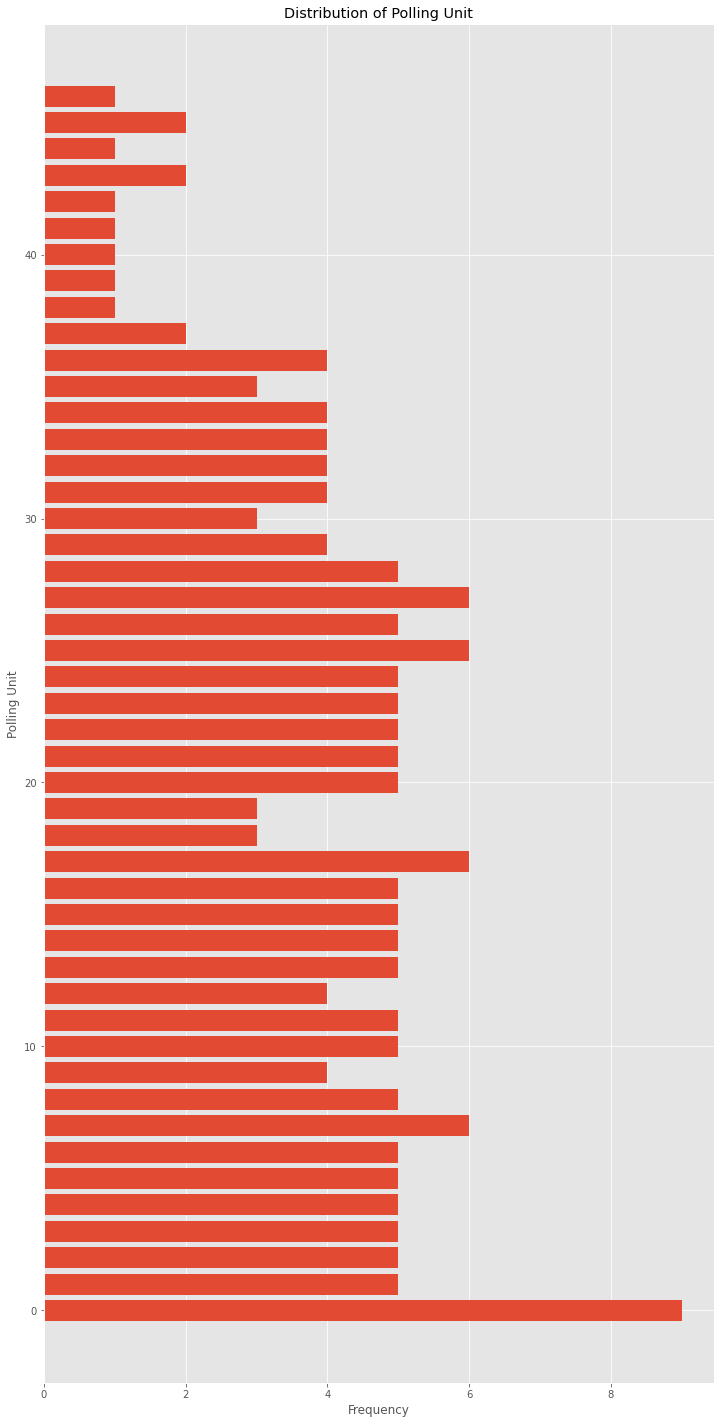

In [5]:
# import seaborn as sns
import matplotlib.pyplot as plt
import collections

c = collections.Counter(recordall['pu'])
c = sorted(c.items())
freq = [i[1] for i in c]
plt.style.use('ggplot')
recordall_num = [i[0] for i in c]
fig, ax = plt.subplots(figsize=(12, 25))
rects = ax.barh(recordall_num, freq)#align='center', alpha=0.5
ax.set_title("Distribution of Polling Unit")
ax.set_ylabel("Polling Unit")
ax.set_xlabel("Frequency")
plt.show()

**It is observed from the graph above that about 9 rows have 0 polling units.
This means that there are some locations without polling units.
Therefore whatever data obtained from such places should be discared for now, for the sake of this analysis.
The only null values observed in the data are from the ra and lga columns where the polling unit values are zero.
This makes it safe to drop all rows containing null values.**

In [6]:
recordall = recordall.dropna()

**The average number of polling units across the wards is presented in the cell below**

In [7]:
Average_pu = recordall['pu'].mean()
Average_pu = round(Average_pu, 3)
print ('The polling unit average:', Average_pu)

The polling unit average: 18.558


**Each column data is converted to the appropriate datatype**

In [8]:
recordall['pu_loc_lat'] = recordall['pu_loc_lat'].astype('float')
recordall['pu_loc_lon'] = recordall['pu_loc_lon'].astype('float')
recordall['ward'] = recordall['ward'].astype('string')
recordall['voting__po'] = recordall['voting__po'].astype('int')

recordall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pu          190 non-null    int64  
 1   pu_loc_lat  190 non-null    float64
 2   pu_loc_lon  190 non-null    float64
 3   ward        190 non-null    string 
 4   voting__po  190 non-null    int64  
dtypes: float64(2), int64(2), string(1)
memory usage: 8.9 KB


**Print the first 24 rows of the cleaned data**

In [9]:
print (recordall.head(24))

    pu  pu_loc_lat  pu_loc_lon                 ward  voting__po
0    1     6.50121     3.38827               MAKOKO         667
1    2     6.49960     3.38802               MAKOKO         987
2    3     6.50080     3.38558               MAKOKO         112
3    4     6.50182     3.38609               MAKOKO         818
4    5     6.49683     3.38629               MAKOKO         746
5    6     6.49607     3.38640               MAKOKO        1006
6    7     6.49720     3.38890               MAKOKO        1335
7    8     6.49848     3.38944               MAKOKO        1092
8    9     6.49648     3.38772               MAKOKO         807
9   10     6.49707     3.38877               MAKOKO         863
10  11     6.49995     3.38694               MAKOKO         976
11  12     6.49995     3.38694               MAKOKO         875
12  13     6.49714     3.38657               MAKOKO         557
13  14     6.49708     3.38685               MAKOKO         644
14  15     6.49741     3.38726          

**A table showing the correlation between the features**

In [10]:
recordall.corr()

,pu,pu_loc_lat,pu_loc_lon,voting__po
pu,1.000000,0.342502,0.344183,-0.016195
pu_loc_lat,0.342502,1.000000,0.999925,0.008809
pu_loc_lon,0.344183,0.999925,1.000000,0.010343
voting__po,-0.016195,0.008809,0.010343,1.000000


**A heatmap is plotted below to better understand the correlation. It can be observed that the longitude and latitude are strongly correlated.**

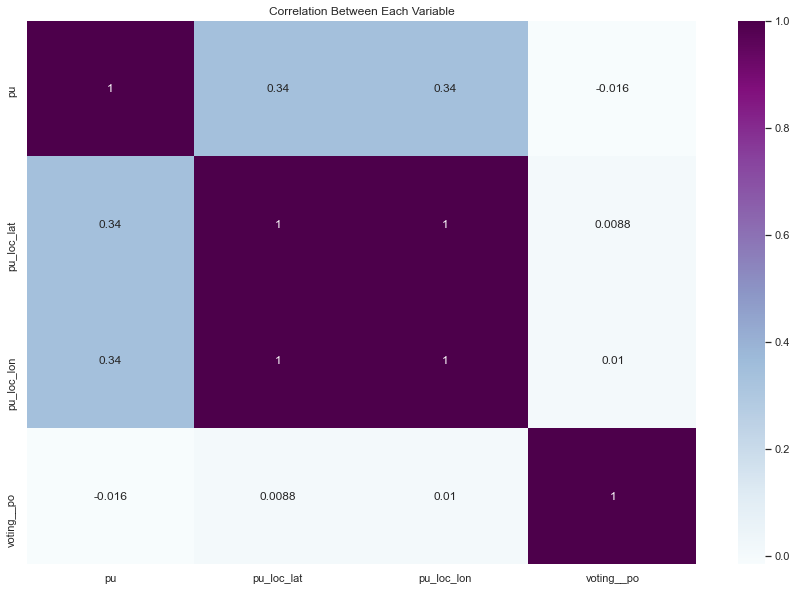

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(recordall.corr(), cmap="BuPu", annot=True)
plt.title("Correlation Between Each Variable")
plt.show()

**The distribution of the voting population is visualized below**

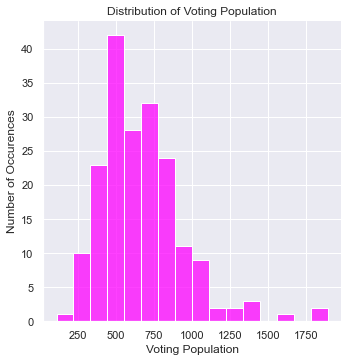

In [12]:
sns.displot(recordall, x="voting__po", color="magenta")
plt.title("Distribution of Voting Population")
plt.ylabel("Number of Occurences")
plt.xlabel("Voting Population")
plt.show()

**The skewness and kurtosis are calculated.
It can be observed from the results that the data is positively skewed and does not deviate too far from the mean**

In [13]:
print('Skewness:', recordall['voting__po'].skew())
print('Kurtosis:', recordall['voting__po'].kurt())


Skewness: 1.393749929756828
Kurtosis: 3.4466134744666026


**The voting population is plotted against the wards in the graph below.
It is observed that ABULE OJA has the highest voting population, followed by HARVEY.
ABULE IJESHA and ALAGOMEJI have the lowest voting population.**

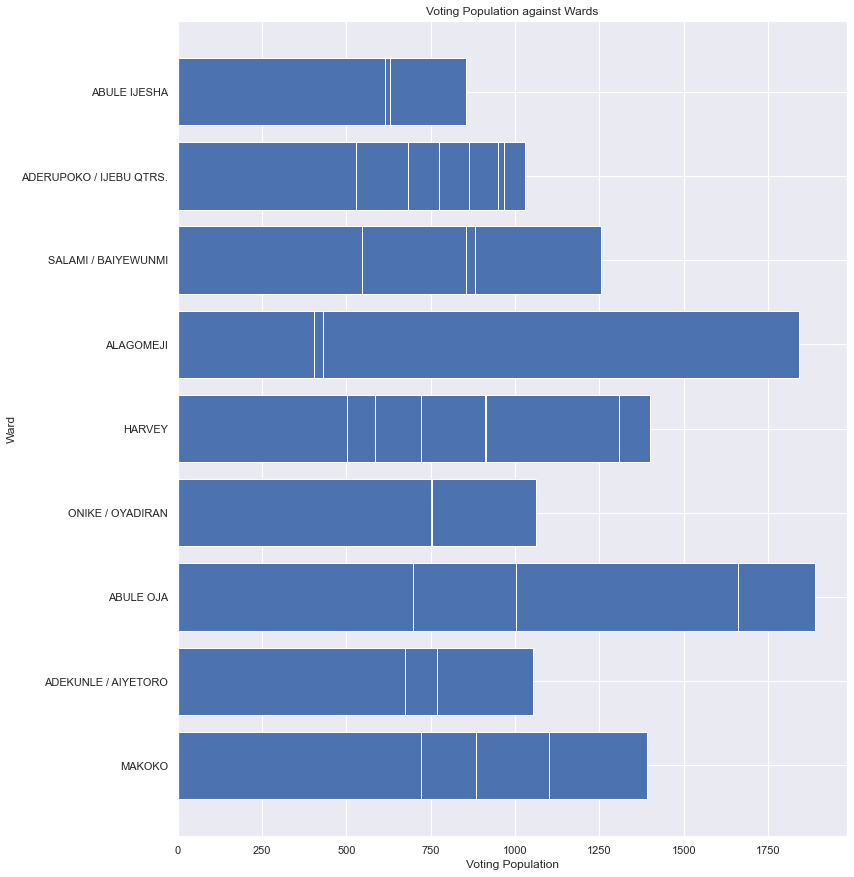

In [14]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12, 15))
rects = ax.barh(recordall['ward'], recordall['voting__po'])#align='center', alpha=0.5
ax.set_title("Voting Population against Wards")
ax.set_ylabel("Ward")
ax.set_xlabel("Voting Population")
plt.show()

**The polling units are plotted against the wards in the graph below.
It is observed that ADEKUNLE/AIYETORO has the highest number of polling units, followed ADERUPOKO/IJEBU QTRS.
Makoko has the lowest number of polling units.**

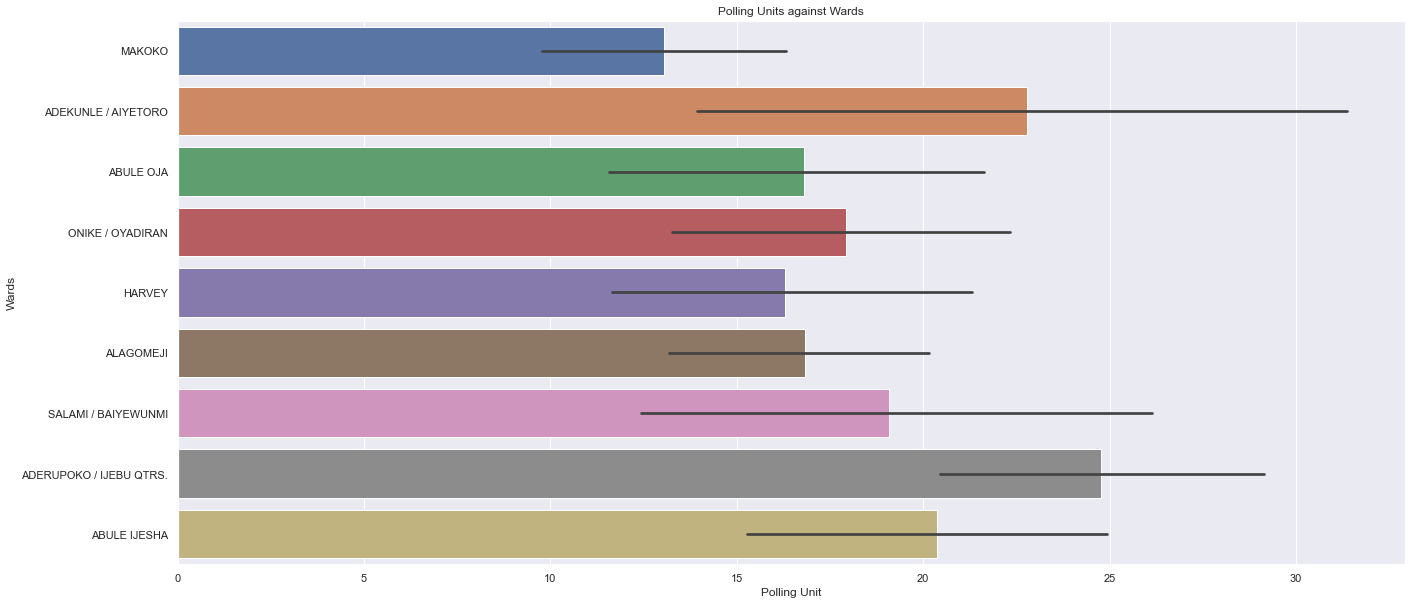

In [15]:
sns.set(rc={'figure.figsize':(22,10)})
sns.barplot(x="pu", y='ward', data=recordall)
plt.ylabel("Wards")
plt.xlabel("Polling Unit")
plt.title("Polling Units against Wards")
plt.show()